In [1]:
%reload_ext autoreload
%reload_ext line_profiler
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, glob, collections, time, itertools

import ujson as json

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import dask
import dask.distributed 

import large_image

import histomicstk as htk
import histomicstk.preprocessing.color_normalization as htk_cnorm
import histomicstk.preprocessing.color_deconvolution as htk_cdeconv
import histomicstk.features as htk_features
import histomicstk.utils as htk_utils
import histomicstk.segmentation.nuclear as htk_nuclear
import histomicstk.segmentation.label as htk_seg_label
import histomicstk.filters.shape as htk_shape_filters

from skimage.filters import threshold_yen, threshold_otsu, threshold_isodata
import skimage.morphology
from skimage.color import label2rgb

import logging
logging.basicConfig(level=logging.CRITICAL)

# sys.path.append(os.path.normpath('/home/deepak.chittajallu/emory/code/HistomicsTK/server'))
# sys.path.append(os.path.normpath('/opt/histomicstk/HistomicsTK/server'))
from cli_common import utils as cli_utils

# import utils as cli_utils  # noqa

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['axes.grid'] = True
plt.gray()

INFO:root:Created LRU Cache for 'tilesource' with 671 maximum size
INFO:root:Notice: Could not import MapnikTileSource


<Figure size 1080x1080 with 0 Axes>

### Define functions

In [23]:
def display_tile_nuclei_annotations(im_tile, tile_info, nuclei_annot_list, args):

    plt.figure()
    plt.imshow(im_tile)

    gx = tile_info['gx']
    gy = tile_info['gy']
    wfrac = tile_info['gwidth'] / np.double(tile_info['width'])
    hfrac = tile_info['gheight'] / np.double(tile_info['height'])

    if args.nuclei_annotation_format == 'boundary':
        
        for obj in nuclei_annot_list:

            pts = np.array(obj['points'])
            bx = pts[:, 0]
            by = pts[:, 1]

            bx -= tile_info["gx"]
            by -= tile_info["gy"]

            bx /= wfrac
            by /= hfrac

            mpoly = mpatches.Polygon(zip(bx, by), fill=False, ec='g', linewidth=2)
            plt.gca().add_patch(mpoly)     
            
    else:
        
        for obj in nuclei_annot_list:

            cx = obj['center'][0]
            cy = obj['center'][1]
            width = obj['width']
            height = obj['height']
            
            cx -= width / 2.0
            cy -= height / 2.0
            
            cx -= tile_info["gx"]
            cy -= tile_info["gy"]
            cx /= wfrac
            cy /= hfrac
            
            width /= wfrac
            height /= hfrac

            mrect = mpatches.Rectangle((cx,cy), width, height, fill=False, ec='g', linewidth=2)
            plt.gca().add_patch(mrect)           

    plt.grid(True)
    plt.xlim([0, im_tile.shape[1]])
    plt.ylim([0, im_tile.shape[0]])      
    
def save_nuclei_annotation(nuclei_anot_list, anot_name, out_file_name):

    if isinstance(anot_name, list):

        assert(len(anot_name) == nuclei_anot_list)
        
        annotation = [
            {
                "name": anot_name[i],
                "elements": nuclei_anot_list[i]
            }
            
            for i in range(len(anot_name))
        ]
        
    else:
        
        annotation = {
            "name":     anot_name,
            "elements": nuclei_anot_list
        }

    out_file = out_file_name + '.anot'
    
    with open(out_file, 'w') as annotation_file:
        json.dump(annotation, annotation_file)

def detect_nuclei_kofahi_log(im_nuclei_seg_input, im_nuclei_fgnd_mask, min_radius,
                             max_radius, min_nucleus_area, local_max_search_radius, debug=False):
    
    # smooth foreground mask with closing and opening
    im_nuclei_fgnd_mask = skimage.morphology.closing(
        im_nuclei_fgnd_mask, skimage.morphology.disk(3))

    im_nuclei_fgnd_mask = skimage.morphology.opening(
        im_nuclei_fgnd_mask, skimage.morphology.disk(3))

    im_nuclei_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        im_nuclei_fgnd_mask)

    if debug:
        
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(im_nuclei_seg_input)
        plt.title('Nuclei seg input')

        plt.subplot(1, 2, 2)
        plt.imshow(im_nuclei_fgnd_mask)
        plt.title('Nuclei fgnd mask')
    
    # run adaptive multi-scale LoG filter
    im_log_max, im_sigma_max = htk_shape_filters.cdog(
        im_nuclei_seg_input, im_nuclei_fgnd_mask,
        sigma_min=min_radius / np.sqrt(2),
        sigma_max=max_radius / np.sqrt(2)
    )

    # apply local maximum clustering
    im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
        im_log_max, im_nuclei_fgnd_mask, local_max_search_radius)

    # split any objects with disconnected fragments
    im_nuclei_seg_mask = htk.segmentation.label.split(im_nuclei_seg_mask, conn=8)

    # filter out small objects
    im_nuclei_seg_mask = htk.segmentation.label.area_open(
        im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

    if debug:
        
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(im_log_max)
        plt.title('LoG maxima response')

        plt.subplot(1, 2, 2)
        plt.imshow(im_nuclei_seg_input)
        plt.title('Nuclei seg mask')
    
    return im_nuclei_seg_mask

def compute_tile_nuclei_features(slide_path, tile_position, args, it_kwargs,
                                 src_mu_lab=None, src_sigma_lab=None, debug=False):

    start_time = time.time()
    
    # get slide tile source
    ts = large_image.getTileSource(slide_path)

    # get requested tile"
    tile_info = ts.getSingleTile(
        tile_position=tile_position,
        format=large_image.tilesource.TILE_FORMAT_NUMPY,
        **it_kwargs)
    
    # get tile image
    im_tile = tile_info['tile'][:, :, :3]

    prep_time = time.time() - start_time
    
    # perform color normalization
    start_time = time.time()
    
    im_nmzd = htk_cnorm.reinhard(
        im_tile,
        args.reference_mu_lab,
        args.reference_std_lab,
        src_mu=src_mu_lab,
        src_sigma=src_sigma_lab
    )

    # perform color decovolution
    if args.deconv_method == 'ruifrok':
        
        w = cli_utils.get_stain_matrix(args)
        im_stains = htk_cdeconv.color_deconvolution(im_nmzd, w).Stains.astype(np.float)[:, :, :2]

    elif args.deconv_method == 'macenko':
        
        w_est = htk_cdeconv.rgb_separate_stains_macenko_pca(im_tile, 255)
        im_stains = htk_cdeconv.color_deconvolution(im_tile, w_est, 255).Stains.astype(np.float)
        ch1 = htk_cdeconv.find_stain_index(htk_cdeconv.stain_color_map[args.stain_1], w_est)
        ch2 = htk_cdeconv.find_stain_index(htk_cdeconv.stain_color_map[args.stain_2], w_est)
        im_stains = im_stains[:, :, [ch1, ch2]]
        
    else:
        
        raise ValueError('Invalid deconvolution method parameter.')

    if debug:
        
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(im_nmzd)
        plt.title('Normalized')

        plt.subplot(1, 3, 2)
        plt.imshow(im_stains[:, :, 0])
        plt.title('Hematoxylin')

        plt.subplot(1, 3, 3)
        plt.imshow(im_stains[:, :, 1])
        plt.title('Dab')
    
    # compute nuclear foreground mask
    im_fgnd_mask_stain_1 = im_stains[:, :, 0] < threshold_yen(im_stains[:, :, 0])
    im_fgnd_mask_stain_2 = im_stains[:, :, 1] < threshold_yen(im_stains[:, :, 1])
    im_fgnd_seg_mask = im_fgnd_mask_stain_1 | im_fgnd_mask_stain_2
    
    # segment nuclei
    im_nuc_seg_input = np.squeeze(np.min(im_stains[:, :, :2], axis=2))
    
    im_nuclei_seg_mask = detect_nuclei_kofahi_log( 
        im_nuc_seg_input,
        im_fgnd_seg_mask,
        args.min_radius,
        args.max_radius,
        args.min_nucleus_area,
        args.local_max_search_radius,
        debug=debug
    )
    
    if not np.any(im_nuclei_seg_mask):
        return [], None, None
    
    if args.ignore_border_nuclei is True:
        im_nuclei_seg_mask = htk_seg_label.delete_border(im_nuclei_seg_mask)

        if not np.any(im_nuclei_seg_mask):
            return [], None, None
        
    if debug:
        
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(im_tile)

        plt.subplot(1, 2, 2)
        plt.imshow(label2rgb(im_nuclei_seg_mask, im_tile, bg_label=0))
        
    nuc_time = time.time() - start_time
    
    # generate nuclei annotations
    start_time = time.time()
    
    nuclei_annot_list = cli_utils.create_tile_nuclei_annotations(
        im_nuclei_seg_mask, tile_info, args.nuclei_annotation_format)

    num_nuclei = len(nuclei_annot_list)
    
    anot_time = time.time() - start_time
    
    # compute nuclei features
    start_time = time.time()
    
    stain_names = [args.stain_1, args.stain_2]

    fdata = [None]*2
    
    for i in range(2):
        
        fdata[i] = htk_features.compute_nuclei_features(
            im_nuclei_seg_mask, im_stains[:, :, i],
            fsd_bnd_pts=args.fsd_bnd_pts,
            fsd_freq_bins=args.fsd_freq_bins,
            num_glcm_levels=args.num_glcm_levels,
            morphometry_features_flag=(args.morphometry_features and i == 0),
            fsd_features_flag=(args.fsd_features and i == 0),
            intensity_features_flag=args.intensity_features,
            gradient_features_flag=args.gradient_features
        )

        fdata[i].columns = ['Feature.{}.'.format(stain_names[i]) + col for col in fdata[i].columns]

    fdata = pd.concat(fdata, axis=1)
    
    fex_time = time.time() - start_time
    
    slide_name = os.path.basename(slide_path)
    print('{}, Tile {}, Num nuclei = {}, load_time = {}, nuc_time = {}, anot_time = {}, fex_time = {}'.format(
        slide_name, tile_position, num_nuclei, prep_time, nuc_time, anot_time, fex_time))
    
    assert len(nuclei_annot_list) == len(fdata), 'ERROR - {}, Tile {}, num_nuclei != num_feature_rows'.format(slide_name, tile_position)

    return nuclei_annot_list, fdata, (prep_time, anot_time, nuc_time, fex_time)
        
def compute_slide_nuclei_features(slide_path, out_dir, args):
    
    assert(args.feature_file_format in ['csv', 'hdf'])

    total_start_time = time.time()
    
    #
    # Read Input Image
    #
    print('\n>> Reading input image ... \n')
        
    ts = large_image.getTileSource(slide_path)
    ts_metadata = ts.getMetadata()

    print(json.dumps(ts_metadata, indent=2))
    
    #
    # Compute tissue/foreground mask at low-res
    #
    print('\n>> Computing tissue/foreground mask at low-res ... \n')
    
    start_time = time.time()

    im_fgnd_mask_lres, fgnd_seg_scale = \
        cli_utils.segment_wsi_foreground_at_low_res(ts)

    fgnd_time = time.time() - start_time

    print('low-res foreground mask computation time = {}'.format(
        cli_utils.disp_time_hms(fgnd_time)))
    
    #    
    # Compute foreground fraction of tiles in parallel using Dask
    #
    print('\n>> Computing foreground fraction of all tiles ...\n')

    it_kwargs = {
        'tile_size': {'width': args.analysis_tile_size},
        'scale': {'magnification': args.analysis_mag},
        'resample': True
    }

    start_time = time.time()

    num_tiles = ts.getSingleTile(**it_kwargs)['iterator_range']['position']

    print('Number of tiles = {}'.format(num_tiles))

    tile_fgnd_frac_list = htk_utils.compute_tile_foreground_fraction(
        slide_path, im_fgnd_mask_lres, fgnd_seg_scale,
        it_kwargs
    )

    num_fgnd_tiles = np.count_nonzero(
        tile_fgnd_frac_list >= args.min_fgnd_frac)

    percent_fgnd_tiles = 100.0 * num_fgnd_tiles / num_tiles

    fgnd_frac_comp_time = time.time() - start_time

    print('Number of foreground tiles = {:d} ({:2f}%)'.format(
        num_fgnd_tiles, percent_fgnd_tiles))

    print('Tile foreground fraction computation time = {}'.format(
        cli_utils.disp_time_hms(fgnd_frac_comp_time)))

    #
    # Compute reinhard stats for color normalization
    #
    src_mu_lab = None
    src_sigma_lab = None

    print('\n>> Computing reinhard color normalization stats ...\n')

    start_time = time.time()

    src_mu_lab, src_sigma_lab = htk_cnorm.reinhard_stats(
        slide_path, 0.01, magnification=args.analysis_mag, tissue_seg_mag=0.625)

    rstats_time = time.time() - start_time

    print('Reinhard stats computation time = {}'.format(
        cli_utils.disp_time_hms(rstats_time)))
    
    #
    # Detect and compute nuclei features in parallel using Dask
    #
    print('\n>> Detecting nuclei and computing features ...\n')

    start_time = time.time()

    tile_result_list = []

    for tile in ts.tileIterator(**it_kwargs):

        tile_position = tile['tile_position']['position']

        if tile_fgnd_frac_list[tile_position] <= args.min_fgnd_frac:
            continue

        if tile['width'] != args.analysis_tile_size or tile['height'] != args.analysis_tile_size:
            continue
        
        # detect nuclei
        cur_result = dask.delayed(compute_tile_nuclei_features)(
            slide_path,
            tile_position,
            args, it_kwargs,
            src_mu_lab, src_sigma_lab
        )

        # append result to list
        tile_result_list.append(cur_result)
    
    # tile_result_list = dask.delayed(tile_result_list).compute()
    tile_result_list = dask.compute(*tile_result_list)

    nuclei_annot_list = [annot
                         for annot_list, fdata, time_stats in tile_result_list
                         for annot in annot_list]

    nuclei_fdata = pd.concat([
        fdata for annot_list, fdata, time_stats in tile_result_list if fdata is not None],
        ignore_index=True)

    comp_time_stats = np.array([
        time_stats for annot_list, fdata, time_stats in tile_result_list if time_stats is not None])
    
    assert(len(nuclei_annot_list) == len(nuclei_fdata))
    
    nuclei_detection_time = time.time() - start_time

    num_nuclei = len(nuclei_annot_list)
    
    print('Number of nuclei = {}'.format(num_nuclei))
    print('Nuclei feature extraction time = {}'.format(cli_utils.disp_time_hms(nuclei_detection_time)))
    print('Mean computational time = {}'.format(np.mean(comp_time_stats, 0)))
    print('Std computational time = {}'.format(np.std(comp_time_stats, 0)))

    #
    # Write annotation file
    #
    print('\n>> Writing annotation file ...\n')

    out_file_name = os.path.basename(slide_path)
    out_file_prefix = os.path.join(out_dir, out_file_name)
    annot_name = out_file_name + '-whole-slide-nuclei-kofahi'
    
    save_nuclei_annotation(nuclei_annot_list, annot_name, out_file_prefix)

    #
    # Create CSV Feature file
    #
    print('>> Writing CSV feature file')

    if args.feature_file_format == 'csv':
        
        nuclei_fdata.to_csv(out_file_prefix + '.csv', index=False, float_format='%.4f')
        
    elif args.feature_file_format == 'hdf':
        
        nuclei_fdata.to_hdf(out_file_prefix + '.hdf', key='features', format='table', mode='w')
        
    else:
        
        raise ValueError('Invalid output format {} for feature file. Must be csv or hdf.'.format(args.output_format))

    total_time_taken = time.time() - total_start_time

    print('Total analysis time = {}'.format(
        cli_utils.disp_time_hms(total_time_taken)))
    
    return num_nuclei

In [8]:
def detect_tile_nuclei(slide_path, tile_position, args, it_kwargs,
                       src_mu_lab=None, src_sigma_lab=None, debug=False):
    
    # get slide tile source
    ts = large_image.getTileSource(slide_path)

    # get requested tile"
    tile_info = ts.getSingleTile(
        tile_position=tile_position,
        format=large_image.tilesource.TILE_FORMAT_NUMPY,
        **it_kwargs)
    
    # get tile image
    im_tile = tile_info['tile'][:, :, :3]

    # perform color normalization
    im_nmzd = htk_cnorm.reinhard(
        im_tile,
        args.reference_mu_lab,
        args.reference_std_lab,
        src_mu=src_mu_lab,
        src_sigma=src_sigma_lab
    )

    # perform color decovolution
    if args.deconv_method == 'ruifrok':
        
        w = cli_utils.get_stain_matrix(args)
        im_stains = htk_cdeconv.color_deconvolution(im_nmzd, w).Stains.astype(np.float)[:, :, :2]

    elif args.deconv_method == 'macenko':
        
        w_est = htk_cdeconv.rgb_separate_stains_macenko_pca(im_tile, 255)
        im_stains = htk_cdeconv.color_deconvolution(im_tile, w_est, 255).Stains.astype(np.float)
        ch1 = htk_cdeconv.find_stain_index(htk_cdeconv.stain_color_map[args.stain_1], w_est)
        ch2 = htk_cdeconv.find_stain_index(htk_cdeconv.stain_color_map[args.stain_2], w_est)
        im_stains = im_stains[:, :, [ch1, ch2]]
        
    else:
        
        raise ValueError('Invalid deconvolution method parameter.')

    if debug:
        
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(im_nmzd)
        plt.title('Normalized')

        plt.subplot(1, 3, 2)
        plt.imshow(im_stains[:, :, 0])
        plt.title('Hematoxylin')

        plt.subplot(1, 3, 3)
        plt.imshow(im_stains[:, :, 1])
        plt.title('Dab')
    
    # compute nuclear foreground mask
    im_fgnd_mask_stain_1 = im_stains[:, :, 0] < threshold_yen(im_stains[:, :, 0])
    im_fgnd_mask_stain_2 = im_stains[:, :, 1] < threshold_yen(im_stains[:, :, 1])
    im_fgnd_seg_mask = im_fgnd_mask_stain_1 | im_fgnd_mask_stain_2
    
    # segment nuclei
    im_nuc_seg_input = np.squeeze(np.min(im_stains[:, :, :2], axis=2))
    
    im_nuclei_seg_mask = detect_nuclei_kofahi_log( 
        im_nuc_seg_input,
        im_fgnd_seg_mask,
        args.min_radius,
        args.max_radius,
        args.min_nucleus_area,
        args.local_max_search_radius,
        debug=debug
    )
    
    # ignore border nuclei
    if args.ignore_border_nuclei is True:
        im_nuclei_seg_mask = htk_seg_label.delete_border(im_nuclei_seg_mask)
        
    if debug:
        
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(im_tile)
        plt.title('Input tile')

        plt.subplot(1, 2, 2)
        plt.imshow(label2rgb(im_nuclei_seg_mask, im_tile, bg_label=0))
        plt.title('Seg mask overlay')

    # return len(np.unique(im_nuclei_seg_mask)) - 1

    # generate nuclei annotations
    nuclei_annot_list = cli_utils.create_tile_nuclei_annotations(
        im_nuclei_seg_mask, tile_info, args.nuclei_annotation_format)

    return nuclei_annot_list

        
def detect_slide_nuclei(slide_path, args):
    
    total_start_time = time.time()
    
    #
    # Read Input Image
    #
    print('\n>> Reading input image ... \n')
        
    ts = large_image.getTileSource(slide_path)
    ts_metadata = ts.getMetadata()

    print(json.dumps(ts_metadata, indent=2))
    
    #
    # Compute tissue/foreground mask at low-res
    #
    print('\n>> Computing tissue/foreground mask at low-res ... \n')
    
    start_time = time.time()

    im_fgnd_mask_lres, fgnd_seg_scale = \
        cli_utils.segment_wsi_foreground_at_low_res(ts)

    fgnd_time = time.time() - start_time

    print('low-res foreground mask computation time = {}'.format(
        cli_utils.disp_time_hms(fgnd_time)))
    
    #    
    # Compute foreground fraction of tiles in parallel using Dask
    #
    print('\n>> Computing foreground fraction of all tiles ...\n')

    it_kwargs = {
        'tile_size': {'width': args.analysis_tile_size},
        'scale': {'magnification': args.analysis_mag},
        'resample': True
    }

    start_time = time.time()

    num_tiles = ts.getSingleTile(**it_kwargs)['iterator_range']['position']

    print('Number of tiles = {}'.format(num_tiles))

    tile_fgnd_frac_list = htk_utils.compute_tile_foreground_fraction(
        slide_path, im_fgnd_mask_lres, fgnd_seg_scale,
        it_kwargs
    )

    num_fgnd_tiles = np.count_nonzero(
        tile_fgnd_frac_list >= args.min_fgnd_frac)

    percent_fgnd_tiles = 100.0 * num_fgnd_tiles / num_tiles

    fgnd_frac_comp_time = time.time() - start_time

    print('Number of foreground tiles = {:d} ({:2f}%)'.format(
        num_fgnd_tiles, percent_fgnd_tiles))

    print('Tile foreground fraction computation time = {}'.format(
        cli_utils.disp_time_hms(fgnd_frac_comp_time)))

    #
    # Compute reinhard stats for color normalization
    #
    src_mu_lab = None
    src_sigma_lab = None

    print('\n>> Computing reinhard color normalization stats ...\n')

    start_time = time.time()

    src_mu_lab, src_sigma_lab = htk_cnorm.reinhard_stats(
        slide_path, 0.01, magnification=args.analysis_mag, tissue_seg_mag=0.625)

    rstats_time = time.time() - start_time

    print('Reinhard stats computation time = {}'.format(
        cli_utils.disp_time_hms(rstats_time)))
    
    #
    # Detect and compute nuclei features in parallel using Dask
    #
    print('\n>> Detecting nuclei and computing features ...\n')

    start_time = time.time()

    tile_result_list = []

    for tile in ts.tileIterator(**it_kwargs):

        tile_position = tile['tile_position']['position']

        if tile_fgnd_frac_list[tile_position] <= args.min_fgnd_frac:
            continue

        if tile['width'] != args.analysis_tile_size or tile['height'] != args.analysis_tile_size:
            continue
        
        # detect nuclei
        cur_result = dask.delayed(detect_tile_nuclei)(
            slide_path,
            tile_position,
            args, it_kwargs,
            src_mu_lab, src_sigma_lab
        )

        # append result to list
        tile_result_list.append(cur_result)
    
    # tile_result_list = dask.delayed(tile_result_list).compute()
    tile_result_list = dask.compute(*tile_result_list)

    nuclei_annot_list = list(itertools.chain.from_iterable(tile_result_list))
    num_nuclei = len(nuclei_annot_list)
    
    # num_nuclei = np.sum(tile_result_list)
    
    nuclei_detection_time = time.time() - start_time

    print('Number of nuclei = {}'.format(num_nuclei))
    print('Nuclei detection time = {}'.format(
        cli_utils.disp_time_hms(nuclei_detection_time)))

    """
    #
    # Write annotation file
    #
    print('\n>> Writing annotation file ...\n')

    out_file_name = os.path.basename(slide_path)
    annot_name = out_file_name + '-whole-slide-nuclei-kofahi'
    
    save_nuclei_annotation(nuclei_annot_list, annot_name, out_file_name)
    """

### Define parameters

In [9]:
args = {
    
    # 0118_CMYC_01.ndpi
    'reference_mu_lab': [8.97307880463709, -0.048069533099968385, -0.007750513198518623],  
    'reference_std_lab': [0.35412366, 0.08349332, 0.01101242],
    
    'stain_1': 'hematoxylin',
    'stain_2': 'dab',
    'stain_3': 'null',    
    'stain_1_vector': [-1, -1, -1],
    'stain_2_vector': [-1, -1, -1],
    'stain_3_vector': [-1, -1, -1],
    'deconv_method': 'ruifrok',
    
    'min_radius': 6,
    'max_radius': 12,
    'foreground_threshold': 120,
    'min_nucleus_area': 25,
    'local_max_search_radius': 8,
    'ignore_border_nuclei': True,
    
    'nuclei_annotation_format': 'bbox',  # Must be 'bbox' or 'boundary'

    'morphometry_features': False,
    'fsd_features': False,
    'intensity_features': True,
    'gradient_features': True,
    'haralick_features': True,
    'cytoplasm_features': False,
    'cyto_width': 5,
    'fsd_bnd_pts': 128,
    'fsd_freq_bins': 6,
    'num_glcm_levels': 32,
    'feature_file_format': 'hdf',
 
    'min_fgnd_frac': 0.75,
    'analysis_mag': 20,
    'analysis_tile_size': 1024,
    
    'scheduler': 'localhost:8786', # 'ibhpg6-01:8786',  # 'localhost:8786',  # 'SMI-1:8786'    
    'num_workers': -1,
    'num_threads_per_worker': 1
}

args = collections.namedtuple('Parameters', args.keys())(**args)

### Setup dask cluster

In [10]:
c = cli_utils.create_dask_client(args)
display(c)

<Client: scheduler='tcp://10.171.2.164:8786' processes=7 cores=7>

### Do dry run on a single tile

In [11]:
DATA_ROOT_DIR = '/media/nvme/Projects/emory/lymphoma/cmyc'
# DATA_ROOT_DIR = '/EINSTEIN_SLIDES/dlbcl'

# inputImageFile = os.path.join(DATA_ROOT_DIR, '0118_CMYC_01.ndpi')
inputImageFile = os.path.join(DATA_ROOT_DIR, '0023_CMYC_01.svs')
# inputImageFile = os.path.join(DATA_ROOT_DIR, '0038_CMYC_01.svs')
# inputImageFile = os.path.join(DATA_ROOT_DIR, '0114_CMYC_01.ndpi')
# inputImageFile = os.path.join(DATA_ROOT_DIR, '0109_CMYC_01.ndpi')

In [12]:
# get slide tile source
ts = large_image.getTileSource(inputImageFile)

ts_metadata = ts.getMetadata()

is_wsi = ts_metadata['magnification'] is not None
assert(is_wsi)

print 'Metadata : \n', json.dumps(ts_metadata, indent = 2)

analysis_tile_size = {
    'width': int(ts_metadata['tileWidth'] * np.ceil(1.0 * args.analysis_tile_size / ts_metadata['tileWidth'])),
    'height': int(ts_metadata['tileHeight'] * np.ceil(1.0 * args.analysis_tile_size / ts_metadata['tileHeight']))
}

print 'Closest analysis tile size as a multiple of native tile size = ', analysis_tile_size

INFO:root:Using memcached for large_image caching


Metadata : 
{
  "magnification":40.0,
  "levels":10,
  "tileHeight":240,
  "tileWidth":240,
  "sizeX":67727,
  "sizeY":73738,
  "mm_y":0.0002519,
  "mm_x":0.0002519
}
Closest analysis tile size as a multiple of native tile size =  {'width': 1200, 'height': 1200}


0.625
(1152, 1058, 3)


/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


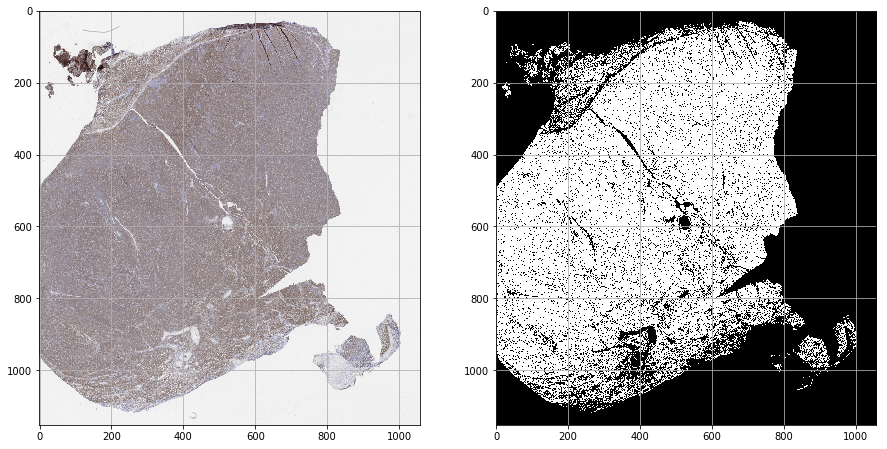

In [13]:
# check foreground segmentation at low-resolution
maxSize = max(ts_metadata['sizeX'], ts_metadata['sizeY'])

fgnd_seg_mag = ts_metadata['magnification'] / 2**np.floor(np.log2(maxSize / 1024))

print fgnd_seg_mag

scale_lres = {'magnification': fgnd_seg_mag}
im_lres, _ = ts.getRegion(
    scale=scale_lres,
    format=large_image.tilesource.TILE_FORMAT_NUMPY,    
)

im_lres = im_lres[:, :, :3]

print im_lres.shape

im_fgnd_mask_lres = htk_utils.simple_mask(im_lres)

plt.subplot(1, 2, 1)
plt.imshow(im_lres)

plt.subplot(1, 2, 2)
plt.imshow(im_fgnd_mask_lres) 

In [14]:
# compute reinhard stats
start_time = time.time()

src_mu_lab, src_sigma_lab = htk_cnorm.reinhard_stats(inputImageFile, 0.01, args.analysis_mag, tissue_seg_mag=0.625)

rstats_time = time.time() - start_time

print('Mean LAB = {}'.format(src_mu_lab))
print('Stddev LAB = {}'.format(src_sigma_lab))
print('Reinhard stats computation time = {} seconds'.format(rstats_time))

Mean LAB = [8.48686869 0.02753153 0.01547152]
Stddev LAB = [0.79538588 0.11844799 0.02256406]
Reinhard stats computation time = 94.124781847 seconds


Number of tiles = 1258


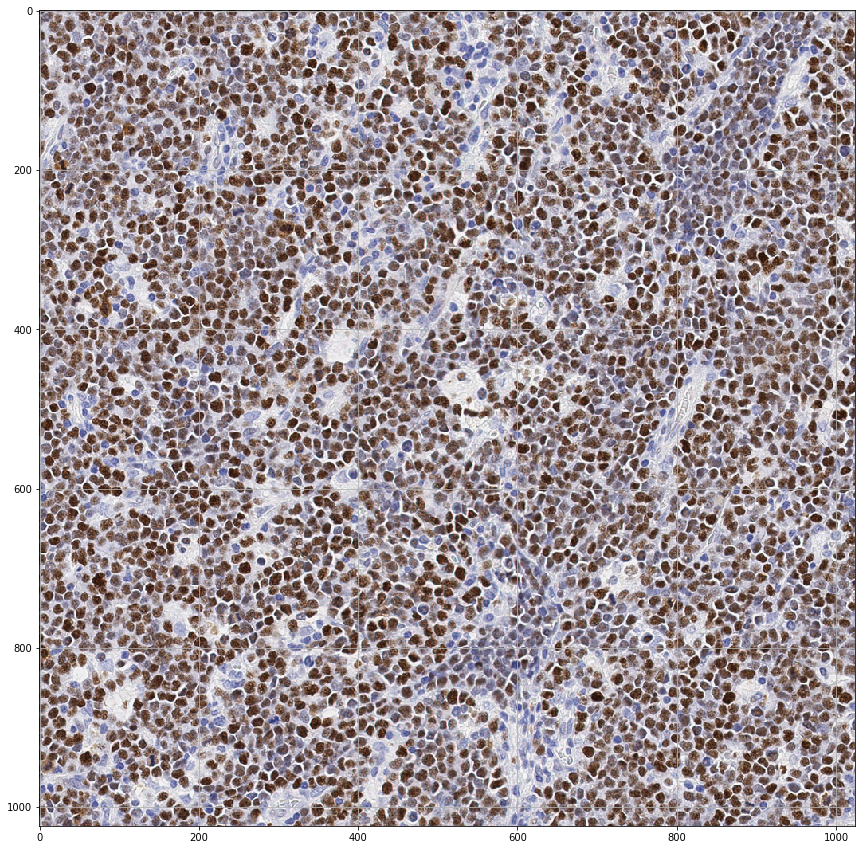

In [15]:
it_kwargs = {
    'tile_size': {'width': args.analysis_tile_size},
    'scale': {'magnification': args.analysis_mag},
    'resample': True
}


num_tiles = ts.getTileCount(**it_kwargs)
print('Number of tiles = {}'.format(num_tiles))

tile_position = 425 # num_tiles / 2

tile_info = ts.getSingleTile(
    tile_position=tile_position,
    format=large_image.tilesource.TILE_FORMAT_NUMPY,
    **it_kwargs)

im_tile = tile_info['tile'][:, :, :3]

plt.imshow(im_tile)

In [14]:
%lprun -f compute_tile_nuclei_features \
    compute_tile_nuclei_features(inputImageFile, tile_position, args, it_kwargs, src_mu_lab, src_sigma_lab)

Tile 425 loading took 0.714125156403 seconds


/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Tile 425 nuclei detection took 4.79413223267 seconds
Tile 425 annotation creation for 2572 nuclei took 8.72297310829 seconds


/home/deepak.chittajallu/work/Projects/EmoryImageAnnotationPlatform/code/HistomicsTK/histomicstk/features/compute_haralick_features.py:322: RuntimeWarning: invalid value encountered in double_scalars
  (np.dot(np.ravel(xy), nGLCMr) - np.square(meanx)) / variance
/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),
/home/deepak.chittajallu/work/Projects/EmoryImageAnnotationPlatform/code/HistomicsTK/histomicstk/features/compute_haralick_features.py:369: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1 - np.exp(-2.0*(HXY2-HXY)))


Tile 425 feature extraction for 2572 nuclei took 65.3856871128 seconds


/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/deepak.chittajallu/work/Projects/EmoryImageAnnotationPlatform/code/HistomicsTK/histomicstk/features/compute_haralick_features.py:322: RuntimeWarning: invalid value encountered in double_scalars
  (np.dot(np.ravel(xy), nGLCMr) - np.square(meanx)) / variance
/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
 

0023_CMYC_01.svs, Tile 425, Num nuclei = 2638, load_time = 0.674613952637, nuc_time = 5.4614648819, anot_time = 0.522567987442, fex_time = 45.781619072
Number of nuclei found = 2638
CPU times: user 54.8 s, sys: 7.07 s, total: 1min 1s
Wall time: 52.4 s


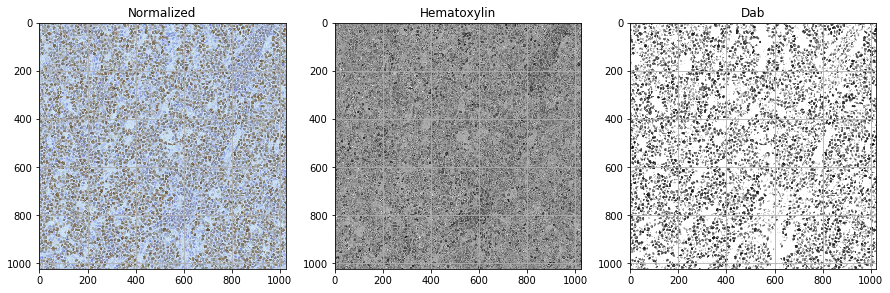

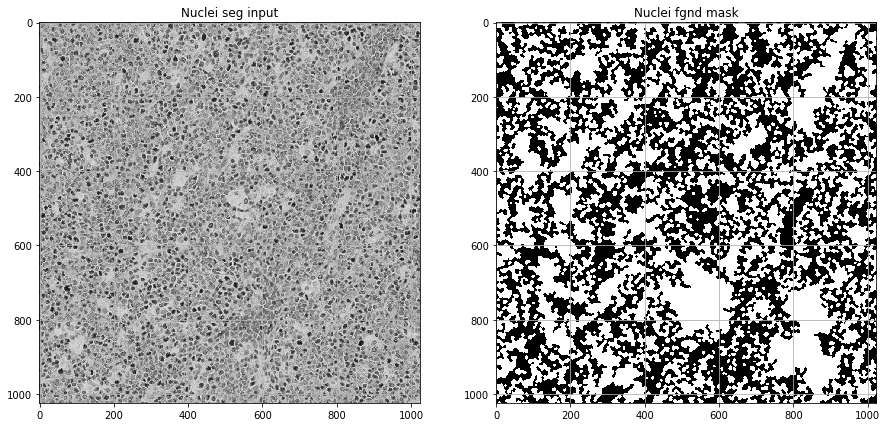

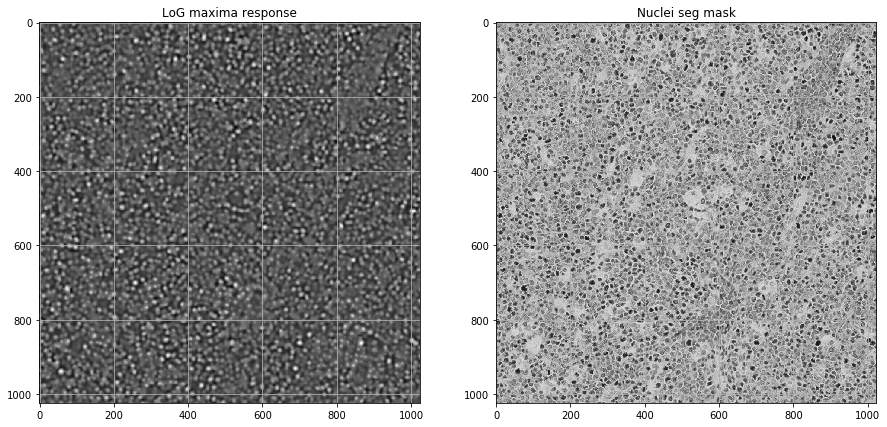

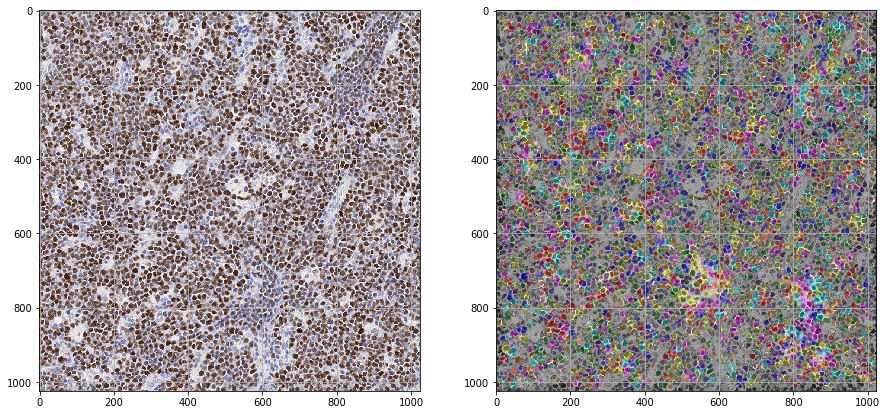

In [16]:
%%time 

nuclei_annot_list, fdata, time_stats = compute_tile_nuclei_features(
    inputImageFile, tile_position, args, it_kwargs, src_mu_lab, src_sigma_lab, debug=True)

print('Number of nuclei found = {}'.format(len(fdata)))

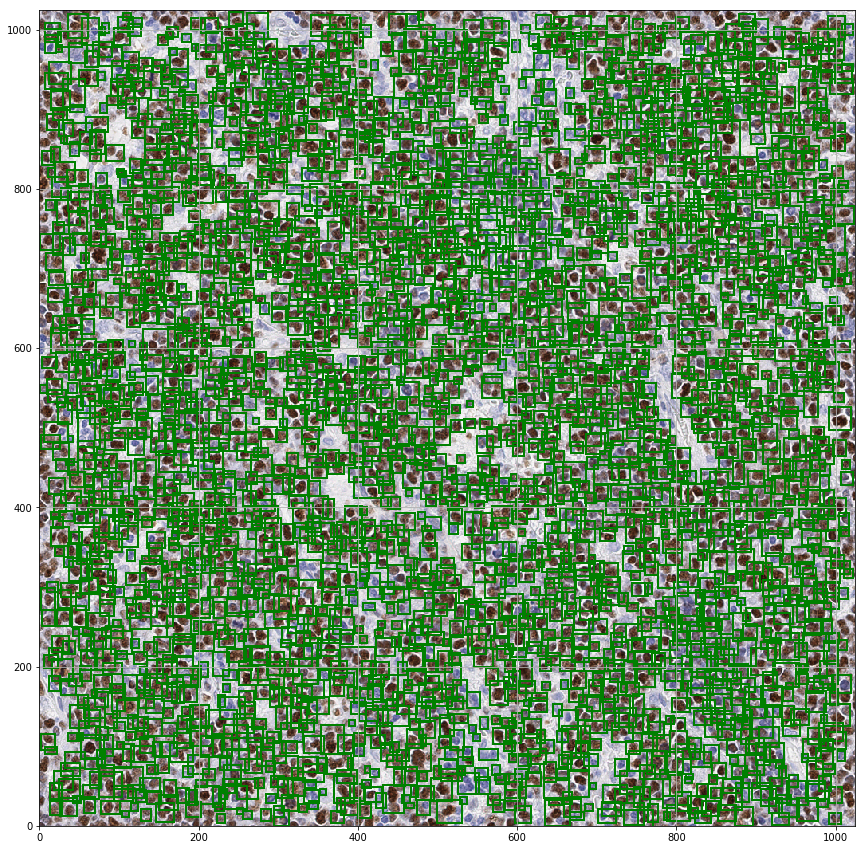

In [17]:
display_tile_nuclei_annotations(im_tile, tile_info, nuclei_annot_list, args)

### Run on a collection of WSI images

In [19]:
DATA_ROOT_DIR = '/media/nvme/Projects/emory/lymphoma/cmyc'
RESULTS_DIR = '/home/deepak.chittajallu/emory/code/IHC-Analysis/BagOfWords/results'

# DATA_ROOT_DIR = '/EINSTEIN_SLIDES/dlbcl'
# RESULTS_DIR = '/home/dchitta/IHC-Analysis/BagOfWords/results'

slide_list = [
    '0023_CMYC_01.svs',    # 2 GB
    '0118_CMYC_01.ndpi',   # 1 GB
    '0038_CMYC_01.svs',    # 2.7 GB
    '0109_CMYC_01.ndpi',   # 819 MB
    '0114_CMYC_01.ndpi',   # 772 MB 
]

In [21]:
c = cli_utils.create_dask_client(args)
display(c)

<Client: scheduler='tcp://10.171.2.164:8786' processes=14 cores=14>

In [22]:
compute_slide_nuclei_features(
    os.path.join(DATA_ROOT_DIR, slide_list[1]), 
    RESULTS_DIR,
    args)


>> Reading input image ... 

{
  "magnification":40.0,
  "levels":10,
  "tileHeight":256,
  "tileWidth":256,
  "sizeX":91264,
  "sizeY":83456,
  "mm_y":0.0002275313,
  "mm_x":0.0002265416
}

>> Computing tissue/foreground mask at low-res ... 

low-res foreground mask computation time = 0:01:49.454711

>> Computing foreground fraction of all tiles ...

Number of tiles = 1845
Number of foreground tiles = 783 (42.439024%)
Tile foreground fraction computation time = 0:00:13.415910

>> Computing reinhard color normalization stats ...

Reinhard stats computation time = 0:00:21.767716

>> Detecting nuclei and computing features ...

Number of nuclei = 1308357
Nuclei feature extraction time = 0:40:58.781372
Mean computational time = [ 0.26803994  0.48757903  4.94379468 37.05848982]
Std computational time = [0.10209097 0.19583877 0.70513987 6.3408423 ]

>> Writing annotation file ...

>> Writing CSV feature file
Total analysis time = 0:43:41.688097


1308357

In [24]:
compute_slide_nuclei_features(
    os.path.join(DATA_ROOT_DIR, slide_list[0]), 
    RESULTS_DIR,
    args)


>> Reading input image ... 

{
  "magnification":40.0,
  "levels":10,
  "tileHeight":240,
  "tileWidth":240,
  "sizeX":67727,
  "sizeY":73738,
  "mm_y":0.0002519,
  "mm_x":0.0002519
}

>> Computing tissue/foreground mask at low-res ... 

low-res foreground mask computation time = 0:00:34.446264

>> Computing foreground fraction of all tiles ...

Number of tiles = 1258
Number of foreground tiles = 531 (42.209857%)
Tile foreground fraction computation time = 0:00:12.353220

>> Computing reinhard color normalization stats ...

Reinhard stats computation time = 0:01:01.662807

>> Detecting nuclei and computing features ...

Number of nuclei = 1229849
Nuclei feature extraction time = 0:37:11.767187
Mean computational time = [ 1.12961743  0.65601876  5.3931446  49.86413989]
Std computational time = [0.26308705 0.27998192 0.73167816 4.43923272]

>> Writing annotation file ...

>> Writing CSV feature file
Total analysis time = 0:39:09.243610


1229849

In [ ]:
compute_slide_nuclei_features(
    os.path.join(DATA_ROOT_DIR, slide_list[2]), 
    RESULTS_DIR,
    args)


>> Reading input image ... 

{
  "magnification":40.0,
  "levels":11,
  "tileHeight":240,
  "tileWidth":240,
  "sizeX":147407,
  "sizeY":78539,
  "mm_y":0.0002519,
  "mm_x":0.0002519
}

>> Computing tissue/foreground mask at low-res ... 

low-res foreground mask computation time = 0:00:20.797220

>> Computing foreground fraction of all tiles ...

Number of tiles = 2808
Number of foreground tiles = 796 (28.347578%)
Tile foreground fraction computation time = 0:00:30.581049

>> Computing reinhard color normalization stats ...

Reinhard stats computation time = 0:01:56.172569

>> Detecting nuclei and computing features ...



In [ ]:
compute_slide_nuclei_features(
    os.path.join(DATA_ROOT_DIR, slide_list[3]), 
    RESULTS_DIR,
    args)

In [ ]:
results = []

start_time = time.time()
use_dask = False

for i in range(2, len(slide_list)):
    
    if not use_dask:
        print('\n########################################################\n')
        print('Processing slide {}/{} - {}'.format(i+1, len(slide_list), slide_list[i]))
    
    cur_slide_path = os.path.join(DATA_ROOT_DIR, slide_list[i])

    if use_dask:
        results.append(dask.delayed(compute_slide_nuclei_features)(cur_slide_path, RESULTS_DIR, args))
    else:
        results.append(compute_slide_nuclei_features(cur_slide_path, RESULTS_DIR, args))
    
if use_dask:
    results = dask.compute(*results)

num_total_nuclei = np.sum(results)

proc_time = time.time() - start_time

print('Total number of nuclei = {}'.format(num_total_nuclei))
print('Total time taken for processing {} slides = {}'.format(len(slide_list), cli_utils.disp_time_hms(proc_time)))